# 10章 サーボ系

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

#plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'cm' # math fontの設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 11 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.5 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'it'#'regular'
plt.rcParams['axes.xmargin'] = '0'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

plt.rcParams["legend.fancybox"] = True     # 丸角
# plt.rcParams["legend.framealpha"] = 1    # 透明度の指定、0で塗りつぶしなし
# plt.rcParams["legend.edgecolor"] = 'gray' # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1.8  # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0.4  # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 0.7 # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 1.0   # 点がある場合のmarker scale

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':', lw=0.5)
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':', lw=0.5)
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':', lw=0.5)
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## サーボ系

In [5]:
A = '0 1; 0 -1'
B = '0; 1'
C = '1 0 ; 0 1'
D = '0; 0'
P = ss(A, B, C, D)
print(P)

C1 = np.matrix([1,0])

A = [[ 0.  1.]
     [ 0. -1.]]

B = [[0.]
     [1.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]



### 例10.1: フィードフォワード項

In [6]:
pole = [-3+3j, -3-3j]
F = -acker(P.A, P.B, pole)

外乱がない場合

[[18.]]


(-0.5, 2.0)

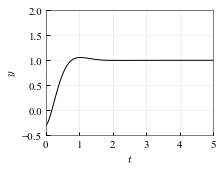

In [7]:
G1 = np.r_[ np.c_[P.A, P.B], np.c_[C1, 0] ]
G1inv = np.linalg.inv(G1)
G2 = np.c_[ np.zeros((1,2)), 1]

G = np.c_[-F, 1] * G1inv * G2.T
print(G)

Acl = P.A + P.B*F
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 5, 0.01)
rd = 1 * (Td>0)

v = G[0,0]*rd

x, t, _ = lsim(Pfb, v, Td, [-0.3, 0.4])

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(t, x[:,0], label = '$x_1$', c='k', lw=1)
# ax.plot(t, x[:,1], ls = '-.', label = '$x_2$', c='k', lw=1)
plot_set(ax, '$t$', '$y$')
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(-0.5,2)

# fig.savefig("sf_serfo_ff.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

外乱がある場合

(-0.5, 2.0)

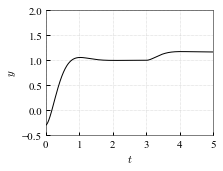

In [8]:
Td = np.arange(0, 5, 0.01)
rd = 1 * (Td>0)
dd = 3 * (Td>3)

v = G[0,0]*rd + dd

x, t, _ = lsim(Pfb, v, Td, [-0.3, 0.4])

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(t, x[:,0], label = '$x_1$', c='k', lw=1)
# ax.plot(t, x[:,1], ls = '-.', label = '$x_2$', c='k', lw=1)
plot_set(ax, '$t$', '$y$')
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(-0.5,2)

#fig.savefig("sf_serfo_ff_dist.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 例10.2: 積分型サーボ

In [9]:
Abar = np.r_[ np.c_[P.A, np.zeros((2,1))], -np.c_[ C1, 0 ] ]
Bbar = np.c_[ P.B.T, 0 ].T
Cbar = np.c_[ C1, 0 ]

Pole = [-3-3j, -3+3j, -5]
F = -acker(Abar, Bbar, Pole)
F

matrix([[-48., -10.,  90.]])

In [10]:
Abar = np.block([ [P.A, np.zeros((2,1))], [ -C1, 0 ] ])
Bbar = np.block([ P.B.T, 0 ]).T
Cbar = np.block([ C1, 0 ])

Pole = [-3-3j, -3+3j, -5]
F = -acker(Abar, Bbar, Pole)
F

matrix([[-48., -10.,  90.]])

(-0.5, 2.0)

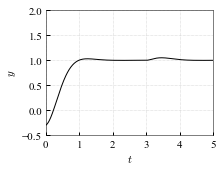

In [11]:
Acl = Abar + Bbar*F
B2 = np.matrix([[0],[0],[1]])
Pfb = ss(Acl, np.c_[Bbar,B2], np.eye(3), np.zeros((3,2)))

Td = np.arange(0, 5, 0.01)
dd = 3 * (Td>3)
x, t, _ = lsim(Pfb, np.c_[dd, rd], Td, [-0.3, 0.4, 0])
 
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$', c='k', lw=1)
# ax.plot(t, x[:,1], ls = '-.',label = '$x_2$')
# ax.plot(t, Ud, c='k')
plot_set(ax, '$t$', '$y$')
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(-0.5,2)

#fig.savefig("servo.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 例10.3: 最適サーボ系

In [12]:
Q = [ [100, 0, 0], [0, 10, 0], [0, 0, 1000]]
R = 1

Fbar, X, E = lqr(Abar, Bbar, Q, R)
Fbar = -Fbar

In [13]:
X11=X[0:2,0:2]
X12=X[0:2,2]
X22=X[2,2]

In [ ]:
F = Fbar[0,0:2]
# FF = -(1/R)*P.B.T*X11
G = Fbar[0,2]
# GG = -(1/R)*P.B.T*X12

In [15]:
H1 = np.r_[ np.c_[P.A, P.B], np.c_[C1, 0] ]
H1inv = np.linalg.inv(H1)
H2 = np.c_[ np.zeros((1,2)), 1]

H = np.c_[-F+G*(1/X22)*X12.T, 1] * H1inv * H2.T

In [16]:
x0 = np.matrix([-0.3, 0.4])
xi0 = - G*(1/X22)*X12.T * x0.T - G*0

(-0.5, 2.0)

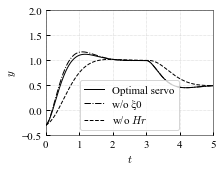

In [17]:
Acl = Abar + Bbar*Fbar
B2 = np.matrix([[0],[0],[1]])
Pfb = ss(Acl, np.c_[Bbar, B2], np.eye(3), np.zeros((3,2)))

Td = np.arange(0, 5, 0.01)
rd = 1 * (Td>0)
dd = -0.5 * (Td>3)
xi0d = xi0 * (Td>=0)

v = np.array(H[0,0]*(rd+dd) + xi0d)

x, t, _ = lsim(Pfb, np.c_[v[0,:],rd+dd], Td, [-0.3, 0.4, 0])
 
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], c='k', lw=1, label='Optimal servo')
#ax.plot(t, x[:,2], ls = '-.',label = '$x_2$')
# ax.plot(t, Ud, c='k')

# 初期値の項がない場合
v = np.array(H[0,0]*(rd+dd) + 0*xi0d)
x, t, _ = lsim(Pfb, np.c_[v[0,:],rd+dd], Td, [-0.3, 0.4, 0])
ax.plot(t, x[:,0], c='k', lw=1, ls='-.', label='w/o ξ0')

# フィードフォワード項がない場合
v = np.array(0*H[0,0]*(rd+dd) + xi0d)
x, t, _ = lsim(Pfb, np.c_[v[0,:],rd+dd], Td, [-0.3, 0.4, 0])
ax.plot(t, x[:,0], c='k', lw =1, ls='--', label='w/o $Hr$')

plot_set(ax, '$t$', '$y$', 'best')
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(-0.5,2)

#fig.savefig("sim2_optimal_servo.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

(-0.5, 2.0)

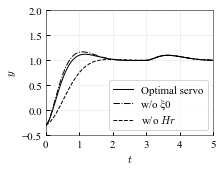

In [18]:
Acl = Abar + Bbar*Fbar
B2 = np.matrix([[0],[0],[1]])
Pfb = ss(Acl, np.c_[Bbar, B2], np.eye(3), np.zeros((3,2)))

Td = np.arange(0, 5, 0.01)
rd = 1 * (Td>0)
dd = 3 * (Td>3)
xi0d = xi0 * (Td>=0)

v = np.array(H[0,0]*rd + xi0d)

x, t, _ = lsim(Pfb, np.c_[dd+v[0,:],rd], Td, [-0.3, 0.4, 0])
 
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], c='k', lw=1, label='Optimal servo')
#ax.plot(t, x[:,2], ls = '-.',label = '$x_2$')
# ax.plot(t, Ud, c='k')

# 初期値の項がない場合
v = np.array(H[0,0]*rd + 0*xi0d)
x, t, _ = lsim(Pfb, np.c_[dd+v[0,:],rd], Td, [-0.3, 0.4, 0])
ax.plot(t, x[:,0], c='k', lw=1, ls='-.', label='w/o ξ0')

# 初期値の項とフィードフォワード項がない場合
v = np.array(0*H[0,0]*rd + xi0d)
x, t, _ = lsim(Pfb, np.c_[dd+v[0,:],rd], Td, [-0.3, 0.4, 0])
ax.plot(t, x[:,0], c='k', lw =1, ls='--', label='w/o $Hr$')

plot_set(ax, '$t$', '$y$', 'best')
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(-0.5,2)

# fig.savefig("sim_optimal_servo.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

In [19]:
print('F=',F)
print('G=',G)
print('H=',H[0,0])
print('xi0=', xi0[0,0])

F= [[-24.24478689  -6.71294845]]
G= 31.622776601677565
H= 14.184692456581072
xi0= -2.496303364255667


## 章末問題

In [20]:
# 章末問題3
Acl = np.matrix([[0, 1, 0], [-2, -3, -2], [1, 1, 0]])
np.linalg.eigvals(Acl)

array([-1.+1.j, -1.-1.j, -1.+0.j])

In [21]:
# 章末問題4
A = '0 1; 2 -1'
B = '0; 1'
C = '2 1'
D = '0'
P = ss(A, B, C, D)
F = np.matrix([-3, -1])

G = -1/(P.C * np.linalg.inv(P.A+P.B*F) * P.B)
print(G)

Abar = np.block([ [P.A, P.B], [ P.C, 0 ] ])
Bbar = np.block([ np.zeros([1,2]), 1 ]).T
Cbar = np.block([ -F, 1 ])
G2 = Cbar*np.linalg.inv(Abar)*Bbar
print(G2)

[[0.5]]
[[0.5]]


In [22]:
# 章末問題5
A = '0 1; -1 -2'
B = '1; 2'
C = '1 0'
D = '0'
P = ss(A, B, C, D)
print(P.zero())

Abar = np.block([ [P.A, np.zeros((2,1))], [ -P.C, 0 ] ])
Bbar = np.block([ P.B.T, 0 ]).T
Cbar = np.block([ P.C, 0 ])

Pole = [-1, -1, -1]
F = -acker(Abar, Bbar, Pole)
F

[-4.+0.j]


matrix([[-0.5 , -0.25,  0.25]])

In [26]:
# -4が零点であることを確認する１
tf(P)

TransferFunction(array([1., 4.]), array([1., 2., 1.]))

In [27]:
# -4が零点であることを確認する２
M = np.block([ [-(-4*np.eye(2) - P.A), P.B], [ P.C, 0 ] ])
M

matrix([[ 4.,  1.,  1.],
        [-1.,  2.,  2.],
        [ 1.,  0.,  0.]])

In [28]:
np.linalg.matrix_rank(M)

2